### Generating human faces with Adversarial Networks
<img src="images/nvidia_cool_gan.png" width="400px"/>
_© research.nvidia.com_

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
!pip freeze

absl-py==0.9.0
backcall==0.1.0
backports.weakref==1.0rc1
bleach==1.5.0
cachetools==3.1.1
certifi==2019.11.28
chardet==3.0.4
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
google-auth==1.9.0
google-auth-oauthlib==0.4.1
grpcio==1.25.0
h5py==2.7.0
html5lib==0.9999999
idna==2.8
ipykernel==4.8.2
ipython==6.5.0
ipython-genutils==0.2.0
ipywidgets==7.3.1
jedi==0.12.1
Jinja2==2.10
joblib==0.12.1
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-contrib-core==0.3.3
jupyter-contrib-nbextensions==0.5.0
jupyter-core==4.4.0
jupyter-highlight-selected-word==0.2.0
jupyter-latex-envs==1.4.4
jupyter-nbextensions-configurator==0.4.0
Keras==2.0.6
lxml==4.2.3
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.0.0
mistune==0.8.3
nbconvert==5.3.1
nbformat==4.4.0
nltk==3.2.4
notebook==5.6.0
numpy==1.17.4
oauthlib==3.1.0
olefile==0.45.1
opencv-python==3.3.0.9
pandas==0.19.2
pandocfilters==1.4.2
parso==0.3.1
pexpect==4.6.0
pickleshare==0.7.4
Pillow==4.0.0
prometheus-client==0

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils
import tqdm_utils

In [2]:
download_utils.link_week_4_resources()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

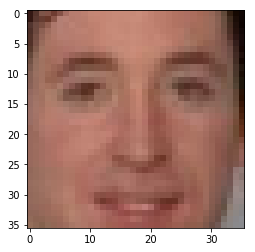

In [4]:
#print random image
np.random.seed(20)
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="images/noise_to_face.png" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [6]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [7]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [8]:
from keras.models import Sequential as Sequential
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

# like autoencoders 
discriminator.add(L.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax, kernel_regularizer=keras.regularizers.l2(0.01)))


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="images/gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [9]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


In [10]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])  # and how close generated ones to being fake

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [11]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])  # how close generated to being real

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [12]:
s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [13]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

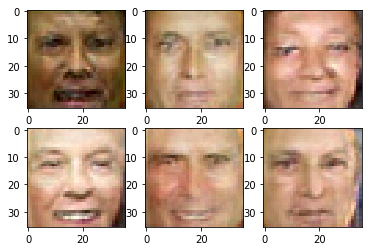

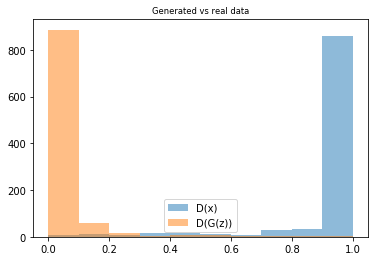

Current epoch 25220
25221
25222
25223
25224
25225


KeyboardInterrupt: 

In [14]:
from IPython import display

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):
    print(epoch)
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %20==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        print('Current epoch', epoch)
        

In [ ]:
from submit_honor import submit_honor
submit_honor((generator, discriminator), 'agimenezzapiola@gmail.com', 'KUgE7YlgyZiA6wY6')

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)